In [23]:
import os
%pwd

'c:\\Users\\Lenovo\\Desktop\\mlops-youtube\\pipe-forecast'

In [24]:
os.chdir("../")
%pwd

'c:\\Users\\Lenovo\\Desktop\\mlops-youtube'

In [ ]:
import pandas as pd
df=pd.read_csv(r"")
df

,UNIQUE_ID,DATE,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,MONTHLY_HOLIDAYS_DAYS_REVENUE,MONTHLY_HOLIDAYS_DAYS_SALES,MONTHLY_WORK_DAYS_SALES,...,ITEM_NAME,ITEM_ID,DATE_ITEM_ID_MONTHLY_SALES_SUM,DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM,DATE_ITEM_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM_LAG1,DATE_ITEM_ID_TOTAL_TRANSACTIONS_SUM,DATE_ITEM_ID_TOTAL_TRANSACTIONS_SUM_LAG1,DATE_ITEM_CATEGORY_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM,DATE_ITEM_CATEGORY_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM_LAG1
0,11-20949,2013-04-01,1,3.0,1,1,3.0,0.0,0.0,0.0,...,Paquete corporativo Mike 1C Interés blanco (34...,20949,199,NaN,59.0,NaN,47,NaN,59.0,NaN
1,11-20949,2013-05-01,4,12.0,3,3,3.0,3.0,1.0,0.0,...,Paquete corporativo Mike 1C Interés blanco (34...,20949,2945,199.0,886.0,59.0,550,47.0,886.0,59.0
2,11-20949,2013-06-01,32,96.0,14,14,3.0,27.0,9.0,3.0,...,Paquete corporativo Mike 1C Interés blanco (34...,20949,6904,2945.0,2660.0,886.0,919,550.0,2660.0,886.0
3,11-20949,2013-07-01,45,135.0,20,20,3.0,30.0,10.0,5.0,...,Paquete corporativo Mike 1C Interés blanco (34...,20949,5787,6904.0,1800.0,2660.0,948,919.0,1800.0,2660.0
4,11-20949,2013-08-01,59,177.0,25,25,3.0,69.0,23.0,8.0,...,Paquete corporativo Mike 1C Interés blanco (34...,20949,5803,5787.0,2023.0,1800.0,898,948.0,2023.0,1800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8741,7-5822,2015-05-01,7,8043.0,7,7,1149.0,4596.0,4.0,2.0,...,PlayStation Tienda Reposición de la billetera:...,5822,225,242.0,68.0,75.0,159,160.0,100.0,103.0
8742,7-5822,2015-06-01,10,11490.0,5,5,1149.0,3447.0,3.0,3.0,...,PlayStation Tienda Reposición de la billetera:...,5822,173,225.0,43.0,68.0,120,159.0,72.0,100.0
8743,7-5822,2015-07-01,4,4596.0,3,3,1149.0,0.0,0.0,0.0,...,PlayStation Tienda Reposición de la billetera:...,5822,163,173.0,38.0,43.0,112,120.0,61.0,72.0
8744,7-5822,2015-08-01,7,8043.0,5,5,1149.0,5745.0,5.0,1.0,...,PlayStation Tienda Reposición de la billetera:...,5822,215,163.0,85.0,38.0,147,112.0,112.0,61.0


In [26]:
df.MONTHLY_REVENUE.value_counts()

MONTHLY_REVENUE
0.0        282
7990.0      41
6993.0      37
9441.0      35
8392.0      34
          ... 
23783.0      1
33579.0      1
19890.5      1
17990.5      1
9841.0       1
Name: count, Length: 3846, dtype: int64

In [27]:
import pickle
import os

from datetime import datetime as dt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
path_data_file=r""
df=pd.read_csv(path_data_file, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87963 entries, 0 to 87962
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                87963 non-null  object 
 1   city                87963 non-null  object 
 2   shop_id             87963 non-null  int64  
 3   shop_name           87963 non-null  object 
 4   item_category_id    87963 non-null  int64  
 5   item_category_name  87963 non-null  object 
 6   item_id             87963 non-null  int64  
 7   item_name           87963 non-null  object 
 8   unique_id           87963 non-null  object 
 9   item_price          87963 non-null  float64
 10  item_cnt_day        87963 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 8.1+ MB


In [29]:
def preprocess_df(df):
    '''
    Preprocess df: upper columns, str date to datetime etc.
    '''
    df.columns = map(str.upper, df.columns)
    df["DATE"] = pd.to_datetime(df["DATE"], format = "%Y-%m-%d")
    df['HOUR'] = df['DATE'].dt.hour
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_of_week

    df["CITY_ID"] = OrdinalEncoder().fit_transform(df[["CITY"]])

    df.rename(columns = {"CITY":"CITY_NAME", "ITEM_CNT_DAY":"SALES"}, inplace = True)
#     df = df[[
#     'DATE',
#     'UNIQUE_ID',
#     'CITY_NAME',
#     'CITY_ID',
#     'SHOP_NAME',
#     'SHOP_ID',
#     'ITEM_CATEGORY_NAME',
#     'ITEM_CATEGORY_ID',
#     'ITEM_NAME',
#     'ITEM_ID',
#     'ITEM_PRICE',
#     'SALES'
# ]]

    return df

In [30]:
df = preprocess_df(df)
df

,DATE,CITY_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,ITEM_ID,ITEM_NAME,UNIQUE_ID,ITEM_PRICE,SALES,HOUR,DAY_OF_WEEK,CITY_ID
0,2013-01-03,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,2,0,3,7.0
1,2013-01-05,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,1,0,5,7.0
2,2013-01-07,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,1,0,0,7.0
3,2013-01-08,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,2,0,1,7.0
4,2013-01-10,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,1,0,3,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87958,2015-09-09,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,17,0,2,7.0
87959,2015-09-10,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,18,0,3,7.0
87960,2015-09-11,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,21,0,4,7.0
87961,2015-09-13,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,11,0,6,7.0


In [31]:
def time_vars(df):
    df.loc[df['DAY_OF_WEEK'] > 4, 'HOLIDAYS_DAYS_REVENUE'] = df['SALES'] * df['ITEM_PRICE']
    df.loc[df['DAY_OF_WEEK'] < 5, 'HOLIDAYS_DAYS_REVENUE'] = 0

    df.loc[df['DAY_OF_WEEK'] < 4, 'WORK_DAYS_SALES'] = 0
    df.loc[df['DAY_OF_WEEK'] > 5, 'WORK_DAYS_SALES'] = df['SALES']

    df.loc[df['DAY_OF_WEEK'] > 4, 'HOLIDAYS_DAYS_SALES'] = df['SALES']
    df.loc[df['DAY_OF_WEEK'] < 5, 'HOLIDAYS_DAYS_SALES'] = 0

    return df

time_vars(df)

,DATE,CITY_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,ITEM_ID,ITEM_NAME,UNIQUE_ID,ITEM_PRICE,SALES,HOUR,DAY_OF_WEEK,CITY_ID,HOLIDAYS_DAYS_REVENUE,WORK_DAYS_SALES,HOLIDAYS_DAYS_SALES
0,2013-01-03,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,2,0,3,7.0,0.0,0.0,0.0
1,2013-01-05,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,1,0,5,7.0,399.0,NaN,1.0
2,2013-01-07,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,1,0,0,7.0,0.0,0.0,0.0
3,2013-01-08,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,2,0,1,7.0,0.0,0.0,0.0
4,2013-01-10,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,1,0,3,7.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87958,2015-09-09,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,17,0,2,7.0,0.0,0.0,0.0
87959,2015-09-10,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,18,0,3,7.0,0.0,0.0,0.0
87960,2015-09-11,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,21,0,4,7.0,0.0,NaN,0.0
87961,2015-09-13,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,11,0,6,7.0,55.0,11.0,11.0


In [32]:
def cash_vars(df):
    df["REVENUE"] = df["ITEM_PRICE"] * df["SALES"]
    df["UNIQUE_DAYS_WITH_SALES"] = df["DATE"]
    df["TOTAL_TRANSACTIONS"] = df["SALES"]
    df['MONTH_DAY'] = df['DATE'].dt.month

    return df

cash_vars(df)

,DATE,CITY_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,ITEM_ID,ITEM_NAME,UNIQUE_ID,ITEM_PRICE,...,HOUR,DAY_OF_WEEK,CITY_ID,HOLIDAYS_DAYS_REVENUE,WORK_DAYS_SALES,HOLIDAYS_DAYS_SALES,REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTH_DAY
0,2013-01-03,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,...,0,3,7.0,0.0,0.0,0.0,798.0,2013-01-03,2,1
1,2013-01-05,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,...,0,5,7.0,399.0,NaN,1.0,399.0,2013-01-05,1,1
2,2013-01-07,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,...,0,0,7.0,0.0,0.0,0.0,399.0,2013-01-07,1,1
3,2013-01-08,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,...,0,1,7.0,0.0,0.0,0.0,798.0,2013-01-08,2,1
4,2013-01-10,Moscú,25,"Moscú SEC ""Atrium""",55,Música - CD de la producción local,2574,Del Rey Lana Nació para morir la edición de Pa...,25-2574,399.0,...,0,3,7.0,0.0,0.0,0.0,399.0,2013-01-10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87958,2015-09-09,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,...,0,2,7.0,0.0,0.0,0.0,85.0,2015-09-09,17,9
87959,2015-09-10,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,...,0,3,7.0,0.0,0.0,0.0,90.0,2015-09-10,18,9
87960,2015-09-11,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,...,0,4,7.0,0.0,NaN,0.0,105.0,2015-09-11,21,9
87961,2015-09-13,Moscú,25,"Moscú SEC ""Atrium""",71,"Regalos - Bolsas, álbumes, Mats d / ratón",20949,Paquete corporativo Mike 1C Interés blanco (34...,25-20949,5.0,...,0,6,7.0,55.0,11.0,11.0,55.0,2015-09-13,11,9


In [33]:
def groupby_month(df):
    df_monthly_agg = df.set_index("DATE").groupby(["UNIQUE_ID"]).resample("M").agg(
            {
                "SALES":np.sum,
                "REVENUE":np.sum,
                "UNIQUE_DAYS_WITH_SALES":lambda dates: len(set(dates)),
                "TOTAL_TRANSACTIONS":len,
                "ITEM_PRICE":np.mean,
                'HOLIDAYS_DAYS_REVENUE': np.sum,
                'HOLIDAYS_DAYS_SALES': np.sum,
                'WORK_DAYS_SALES': np.sum,
            }
        ).rename(
            columns = {
                "SALES":"MONTHLY_SALES",
                "REVENUE":"MONTHLY_REVENUE",
                "ITEM_PRICE":"MONTHLY_MEAN_PRICE",
                'HOLIDAYS_DAYS_REVENUE': 'MONTHLY_HOLIDAYS_DAYS_REVENUE',
                'HOLIDAYS_DAYS_SALES': 'MONTHLY_HOLIDAYS_DAYS_SALES',
                'WORK_DAYS_SALES': 'MONTHLY_WORK_DAYS_SALES',
            }
        ).reset_index()
    
    return df_monthly_agg

df_monthly_agg=groupby_month(df)
df_monthly_agg

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39792\919811762.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_agg = df.set_index("DATE").groupby(["UNIQUE_ID"]).resample("M").agg(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39792\919811762.py:2: FutureWarning: The provided callable <function sum at 0x000002E4B5888C20> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_monthly_agg = df.set_index("DATE").groupby(["UNIQUE_ID"]).resample("M").agg(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39792\919811762.py:2: FutureWarning: The provided callable <function sum at 0x000002E4B5888C20> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_monthly_agg

,UNIQUE_ID,DATE,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,MONTHLY_HOLIDAYS_DAYS_REVENUE,MONTHLY_HOLIDAYS_DAYS_SALES,MONTHLY_WORK_DAYS_SALES
0,11-20949,2013-04-30,1,3.0,1,1,3.0,0.0,0.0,0.0
1,11-20949,2013-05-31,4,12.0,3,3,3.0,3.0,1.0,0.0
2,11-20949,2013-06-30,32,96.0,14,14,3.0,27.0,9.0,3.0
3,11-20949,2013-07-31,45,135.0,20,20,3.0,30.0,10.0,5.0
4,11-20949,2013-08-31,59,177.0,25,25,3.0,69.0,23.0,8.0
...,...,...,...,...,...,...,...,...,...,...
8741,7-5822,2015-05-31,7,8043.0,7,7,1149.0,4596.0,4.0,2.0
8742,7-5822,2015-06-30,10,11490.0,5,5,1149.0,3447.0,3.0,3.0
8743,7-5822,2015-07-31,4,4596.0,3,3,1149.0,0.0,0.0,0.0
8744,7-5822,2015-08-31,7,8043.0,5,5,1149.0,5745.0,5.0,1.0


In [34]:
#"2015-10-31"
def range(date):
    MIN_DATE = df["DATE"].min()
    MAX_DATE = df["DATE"].max()
    DATE_PREDICTION = np.datetime64(date)
    unique_id = sorted(df_monthly_agg["UNIQUE_ID"].unique())
    date_range = pd.date_range(MIN_DATE, DATE_PREDICTION, freq = "M")
    cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["DATE", "UNIQUE_ID"])
    full_df = pd.DataFrame(index = cartesian_product).reset_index()
    full_df = pd.merge(full_df, df_monthly_agg, on = ['DATE','UNIQUE_ID'], how = 'left')
    add_info = df[
    ["UNIQUE_ID", "CITY_NAME", "CITY_ID", "SHOP_NAME", "SHOP_ID", "ITEM_CATEGORY_NAME", "ITEM_CATEGORY_ID", "ITEM_NAME", "ITEM_ID"]
        ].drop_duplicates()
    full_df = pd.merge(
    left = full_df,
    right = add_info,
    how = "left",
    on = "UNIQUE_ID"
    )

    return full_df

full_df=range("2015-10-31")
full_df

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39792\124911486.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(MIN_DATE, DATE_PREDICTION, freq = "M")


,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,MONTHLY_HOLIDAYS_DAYS_REVENUE,MONTHLY_HOLIDAYS_DAYS_SALES,MONTHLY_WORK_DAYS_SALES,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,2013-01-31,11-20949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949
1,2013-01-31,11-4181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4181
2,2013-01-31,12-11365,35.0,43299.999999,12.0,12.0,1511.512626,0.0,0.0,0.0,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (EMS),11365
3,2013-01-31,12-11369,42.0,21220.000000,12.0,12.0,572.715278,910.0,1.0,0.0,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (correo),11369
4,2013-01-31,12-11370,62.0,30750.000000,16.0,16.0,699.776786,0.0,0.0,0.0,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (en Moscú),11370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10161,2015-10-31,6-5823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Voronezh,22.0,"Voronezh (Plekhanovskaya, 13)",6,Las tarjetas de pago - PSN,35,PlayStation Store Replenishment Wallet: Mapa d...,5823
10162,2015-10-31,6-7856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Voronezh,22.0,"Voronezh (Plekhanovskaya, 13)",6,Juegos PC - Otras publicaciones,28,Mundo de Warcraft. Tiempo de juego Mapa de pag...,7856
10163,2015-10-31,7-17717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Voronezh,22.0,"Voronezh SEC ""Maksimir""",7,Herramientas de sistema,79,Recibir fondos para 1c-online,17717
10164,2015-10-31,7-20949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Voronezh,22.0,"Voronezh SEC ""Maksimir""",7,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949


In [35]:
def drop_nulls(full_df):
    full_df["MONTHLY_SALES"].fillna(0, inplace = True)
    full_df["MONTHLY_REVENUE"].fillna(0, inplace = True)
    full_df["UNIQUE_DAYS_WITH_SALES"].fillna(0, inplace = True)
    full_df["TOTAL_TRANSACTIONS"].fillna(0, inplace = True)

    full_df["MONTHLY_MEAN_PRICE"].fillna(0, inplace = True)
    full_df["MONTHLY_HOLIDAYS_DAYS_REVENUE"].fillna(0, inplace = True)
    full_df["MONTHLY_HOLIDAYS_DAYS_SALES"].fillna(0, inplace = True)
    full_df["MONTHLY_WORK_DAYS_SALES"].fillna(0, inplace = True)

    return full_df

drop_nulls(full_df)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39792\1500526240.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df["MONTHLY_SALES"].fillna(0, inplace = True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39792\1500526240.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,MONTHLY_HOLIDAYS_DAYS_REVENUE,MONTHLY_HOLIDAYS_DAYS_SALES,MONTHLY_WORK_DAYS_SALES,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,2013-01-31,11-20949,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949
1,2013-01-31,11-4181,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4181
2,2013-01-31,12-11365,35.0,43299.999999,12.0,12.0,1511.512626,0.0,0.0,0.0,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (EMS),11365
3,2013-01-31,12-11369,42.0,21220.000000,12.0,12.0,572.715278,910.0,1.0,0.0,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (correo),11369
4,2013-01-31,12-11370,62.0,30750.000000,16.0,16.0,699.776786,0.0,0.0,0.0,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (en Moscú),11370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10161,2015-10-31,6-5823,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Voronezh,22.0,"Voronezh (Plekhanovskaya, 13)",6,Las tarjetas de pago - PSN,35,PlayStation Store Replenishment Wallet: Mapa d...,5823
10162,2015-10-31,6-7856,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Voronezh,22.0,"Voronezh (Plekhanovskaya, 13)",6,Juegos PC - Otras publicaciones,28,Mundo de Warcraft. Tiempo de juego Mapa de pag...,7856
10163,2015-10-31,7-17717,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Voronezh,22.0,"Voronezh SEC ""Maksimir""",7,Herramientas de sistema,79,Recibir fondos para 1c-online,17717
10164,2015-10-31,7-20949,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Voronezh,22.0,"Voronezh SEC ""Maksimir""",7,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949


In [36]:
def build_ts_vars(full_df, gb_list, target_column, agg_func, agg_func_name, verbose = True):

    assert gb_list[0] == "DATE", "First element must be date"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    if verbose: print(new_name)

    gb_df_ = full_df.groupby(gb_list)[target_column].apply(agg_func).to_frame().reset_index().rename(
        columns = {
            target_column : new_name
        }
    )

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.shift(1)
    )

    return gb_df_

In [37]:
def vars_comb(full_df, GL, TARGET_COLUMN, AGG_FUNC, AGG_FUNC_NAME):
    var= build_ts_vars(
        full_df = full_df,
        gb_list = GL,
        target_column = TARGET_COLUMN,
        agg_func = AGG_FUNC,
        agg_func_name = AGG_FUNC_NAME

    )
    full_df = pd.merge(full_df, var , on = GL, how = "left")

    return full_df

full_df=vars_comb(full_df,["DATE", "ITEM_ID"], "MONTHLY_SALES", np.sum, "SUM")
full_df=vars_comb(full_df,["DATE", "ITEM_ID"], "MONTHLY_HOLIDAYS_DAYS_SALES", np.sum, "SUM")
full_df=vars_comb(full_df,["DATE", "ITEM_ID"], "TOTAL_TRANSACTIONS", np.sum, "SUM")
full_df=vars_comb(full_df,["DATE", "ITEM_CATEGORY_ID"], "MONTHLY_HOLIDAYS_DAYS_SALES", np.sum, "SUM")    

DATE_ITEM_ID_MONTHLY_SALES_SUM
DATE_ITEM_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM
DATE_ITEM_ID_TOTAL_TRANSACTIONS_SUM
DATE_ITEM_CATEGORY_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM


In [38]:
def columns_drop(full_df):
    COLUMNS_TO_DROP = [
        'DATE_ITEM_ID_MONTHLY_SALES_SUM',
        'DATE_ITEM_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM',
        'DATE_ITEM_ID_TOTAL_TRANSACTIONS_SUM',
        'DATE_ITEM_CATEGORY_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM',
        'MONTHLY_REVENUE',
        'UNIQUE_DAYS_WITH_SALES',
        'TOTAL_TRANSACTIONS',
        'MONTHLY_MEAN_PRICE',
        'CITY_NAME',
        'SHOP_NAME',
        'ITEM_CATEGORY_NAME',
        'ITEM_NAME',
        'MONTHLY_HOLIDAYS_DAYS_SALES',
        'MONTHLY_WORK_DAYS_SALES'
        ]
    full_df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)
    full_df.set_index("UNIQUE_ID", inplace = True)

    return full_df

columns_drop(full_df)

,DATE,MONTHLY_SALES,MONTHLY_HOLIDAYS_DAYS_REVENUE,CITY_ID,SHOP_ID,ITEM_CATEGORY_ID,ITEM_ID,DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM_LAG1,DATE_ITEM_ID_TOTAL_TRANSACTIONS_SUM_LAG1,DATE_ITEM_CATEGORY_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM_LAG1
UNIQUE_ID,,,,,,,,,,,
11-20949,2013-01-31,0.0,0.0,25.0,11,71,20949,NaN,NaN,NaN,NaN
11-4181,2013-01-31,0.0,0.0,25.0,11,75,4181,NaN,NaN,NaN,NaN
12-11365,2013-01-31,35.0,0.0,16.0,12,9,11365,NaN,NaN,NaN,NaN
12-11369,2013-01-31,42.0,910.0,16.0,12,9,11369,NaN,NaN,NaN,NaN
12-11370,2013-01-31,62.0,0.0,16.0,12,9,11370,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6-5823,2015-10-31,0.0,0.0,22.0,6,35,5823,53.0,13.0,36.0,67.0
6-7856,2015-10-31,0.0,0.0,22.0,6,28,7856,31.0,7.0,27.0,12.0
7-17717,2015-10-31,0.0,0.0,22.0,7,79,17717,418.0,141.0,272.0,141.0


In [39]:
def split(full_df):
    train_index = sorted(list(full_df["DATE"].unique()))[:-2]
    valida_index = [sorted(list(full_df["DATE"].unique()))[-2]]
    test_index = [sorted(list(full_df["DATE"].unique()))[-1]]

    X_train = full_df[full_df["DATE"].isin(train_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
    Y_train = full_df[full_df["DATE"].isin(train_index)]['MONTHLY_SALES']

    X_valida = full_df[full_df["DATE"].isin(valida_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
    Y_valida = full_df[full_df["DATE"].isin(valida_index)]['MONTHLY_SALES']

    X_test = full_df[full_df["DATE"].isin(test_index)].drop(['MONTHLY_SALES', "DATE"], axis = 1)
    Y_test = full_df[full_df["DATE"].isin(test_index)]['MONTHLY_SALES']

    return X_train,X_test,X_valida,Y_train,Y_test,Y_valida

X_train,X_test,X_valida,Y_train,Y_test,Y_valida=split(full_df)


In [40]:
X_train

,MONTHLY_HOLIDAYS_DAYS_REVENUE,CITY_ID,SHOP_ID,ITEM_CATEGORY_ID,ITEM_ID,DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM_LAG1,DATE_ITEM_ID_TOTAL_TRANSACTIONS_SUM_LAG1,DATE_ITEM_CATEGORY_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM_LAG1
UNIQUE_ID,,,,,,,,,
11-20949,0.0,25.0,11,71,20949,NaN,NaN,NaN,NaN
11-4181,0.0,25.0,11,75,4181,NaN,NaN,NaN,NaN
12-11365,0.0,16.0,12,9,11365,NaN,NaN,NaN,NaN
12-11369,910.0,16.0,12,9,11369,NaN,NaN,NaN,NaN
12-11370,0.0,16.0,12,9,11370,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6-5823,2799.0,22.0,6,35,5823,42.0,14.0,36.0,61.0
6-7856,1199.0,22.0,6,28,7856,34.0,5.0,32.0,9.0
7-17717,5196.0,22.0,7,79,17717,383.0,104.0,263.0,104.0


In [41]:
def model():
    model = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, seed = 175)

    model_name = str(model).split("(")[0]

    day = str(dt.now()).split()[0].replace("-", "_")
    hour = str(dt.now()).split()[1].replace(":", "_").split(".")[0]
    t = str(day) + "_" + str(hour)

    model.fit(X_train, Y_train,
        eval_set = [(X_train, Y_train), (X_valida, Y_valida)],
        verbose = True)
    
    return model

model = model()

[0]	validation_0-rmse:53.87468	validation_1-rmse:38.17184
[1]	validation_0-rmse:41.70591	validation_1-rmse:28.59742
[2]	validation_0-rmse:33.04716	validation_1-rmse:20.86095
[3]	validation_0-rmse:27.11359	validation_1-rmse:16.89612
[4]	validation_0-rmse:23.08598	validation_1-rmse:14.81453
[5]	validation_0-rmse:20.22146	validation_1-rmse:13.34853
[6]	validation_0-rmse:18.35643	validation_1-rmse:12.79125
[7]	validation_0-rmse:17.15109	validation_1-rmse:12.03911
[8]	validation_0-rmse:16.35246	validation_1-rmse:12.05856
[9]	validation_0-rmse:15.52730	validation_1-rmse:12.04676
[10]	validation_0-rmse:14.76611	validation_1-rmse:11.68909
[11]	validation_0-rmse:14.34202	validation_1-rmse:11.52149
[12]	validation_0-rmse:13.93335	validation_1-rmse:11.29470
[13]	validation_0-rmse:13.70236	validation_1-rmse:11.13249
[14]	validation_0-rmse:13.53983	validation_1-rmse:11.25803
[15]	validation_0-rmse:13.22709	validation_1-rmse:11.01963
[16]	validation_0-rmse:13.02158	validation_1-rmse:10.97492
[17]	va

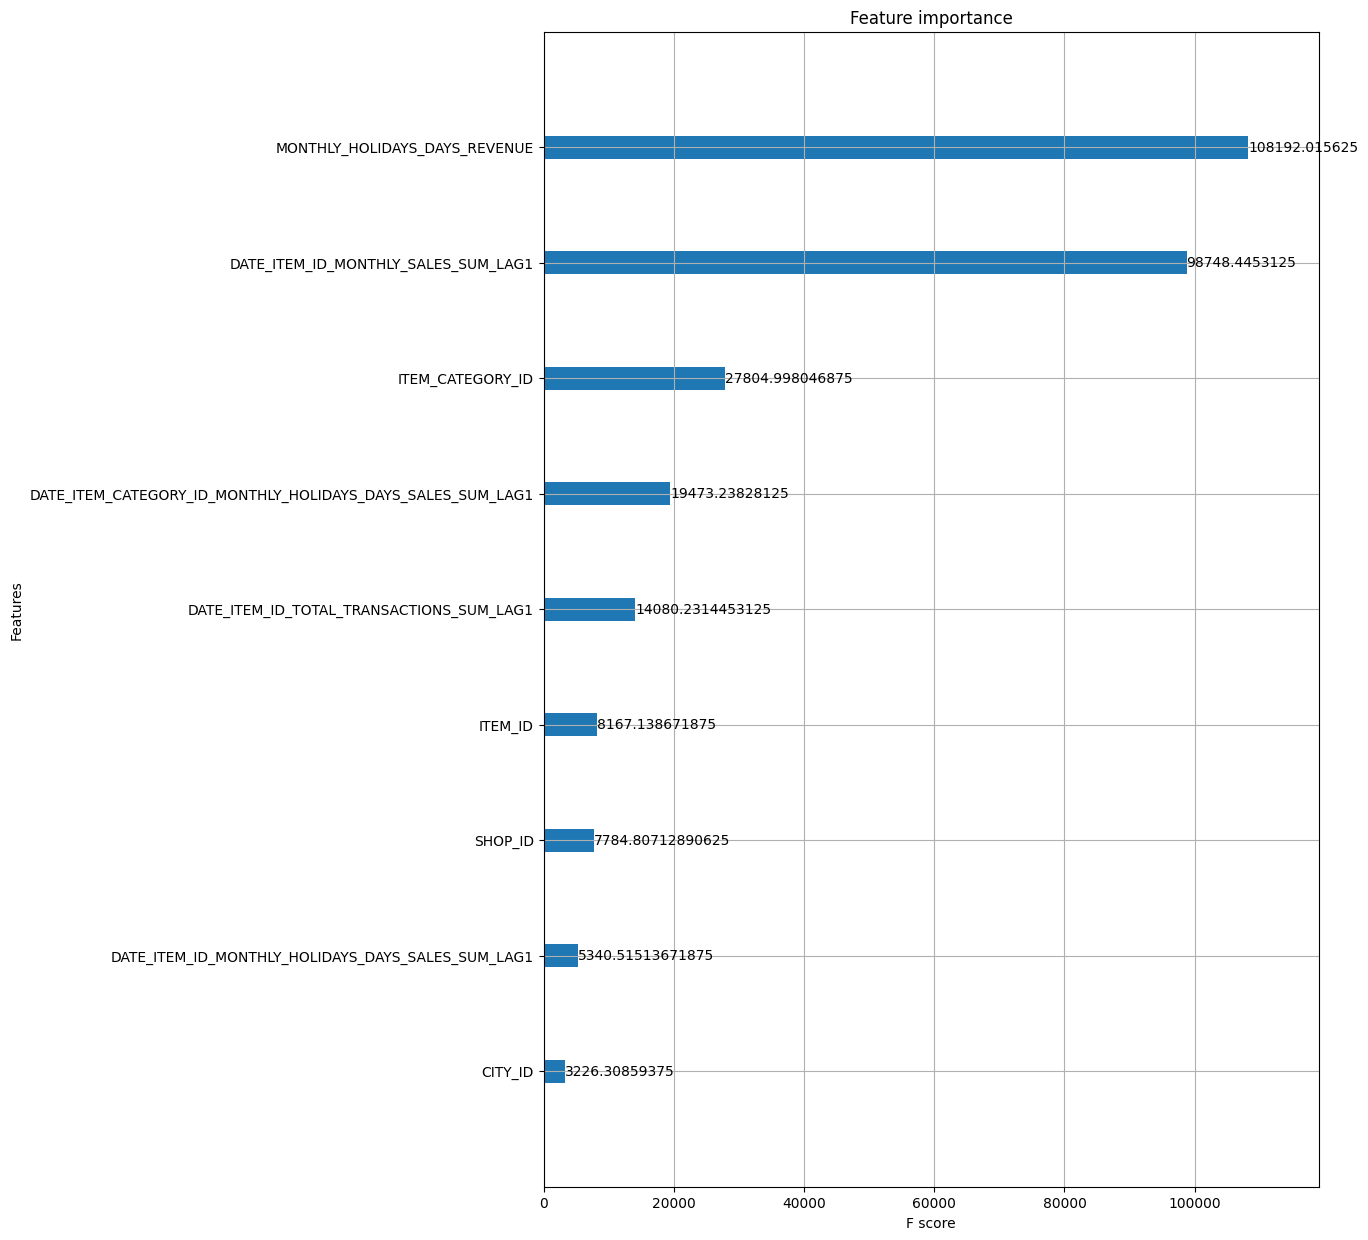

In [42]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

In [ ]:
# MONTHLY_HOLIDAYS_DAYS_REVENUE,
# CITY_ID,
# SHOP_ID,
# ITEM_CATEGORY_ID,
# ITEM_ID,
# DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1,
# DATE_ITEM_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM_LAG1,
# DATE_ITEM_ID_TOTAL_TRANSACTIONS_SUM_LAG1,
# DATE_ITEM_CATEGORY_ID_MONTHLY_HOLIDAYS_DAYS_SALES_SUM_LAG1